In [1]:
# import os
# os.chdir('/Users/evanli/Documents/EvanPys/Progress/')

# from ADlasso2 import AD2_w_utils as ad
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import scipy
import sklearn
import copy
import importlib


## Read result_dict from json

In [2]:
!pwd

/Users/evanli/Documents/EvanPys/Progress/PBMC_Hao/Leiden_alpha0.001


In [3]:
clusters = ['0', '1']

In [4]:
import json

loss_dict = {}
opt_lambda_dict = {}
prevalence_dict = {}
precision_dict = {}
f1_dict = {}

for c in clusters:
    print('Processing: ', c)
    # /Users/evanli/Documents/EvanPys/Progress/PBMC_Hao/PBMC_AD2_result/ASDC
    with open(f'./cluster_{c}/{c}_tuning.json') as f:
    # with open(f'./{c}_tuning.json') as f:
        result_dict = json.load(f)
    result_dict = {key: np.array(value) for key, value in result_dict.items()}

    # opt_lmbd, fig = ad.lambda_decision(result_dict, k=2)
    # opt_lambda_dict[celltype] = opt_lmbd
    # print('Optimal lambda: {}'.format(opt_lmbd))

    # Read optimal lambda
#     with open(f'./{celltype}/{celltype}_opt_lambda.txt', 'r') as f:
    with open(f'./cluster_{c}/{c}_opt_lambda.txt', 'r') as f:
        opt_lmbd = float(f.read())
    opt_lambda_dict[c] = opt_lmbd

    loss_dict[c] = result_dict['loss_history']
    prevalence_dict[c] = result_dict['Prevalence']
    precision_dict[c] = result_dict['Precision']
    f1_dict[c] = result_dict['F1 score']

Processing:  0
Processing:  1


In [7]:
opt_lambda_dict

{'0': 0.004641588833612781, '1': 0.006812920690579619}

## Plot summary loss vs. prevalance

In [8]:
log_lmbd_range = np.linspace(np.log(1e-4), np.log(1), 25)
lmbd_range = np.exp(log_lmbd_range)
print(lmbd_range)

[1.00000000e-04 1.46779927e-04 2.15443469e-04 3.16227766e-04
 4.64158883e-04 6.81292069e-04 1.00000000e-03 1.46779927e-03
 2.15443469e-03 3.16227766e-03 4.64158883e-03 6.81292069e-03
 1.00000000e-02 1.46779927e-02 2.15443469e-02 3.16227766e-02
 4.64158883e-02 6.81292069e-02 1.00000000e-01 1.46779927e-01
 2.15443469e-01 3.16227766e-01 4.64158883e-01 6.81292069e-01
 1.00000000e+00]


In [11]:
# create color palette for 8 cell types
import seaborn as sns

keys = list(loss_dict.keys())
palette = sns.color_palette('tab10', n_colors=len(keys))
color_dict = dict(zip(keys, palette))

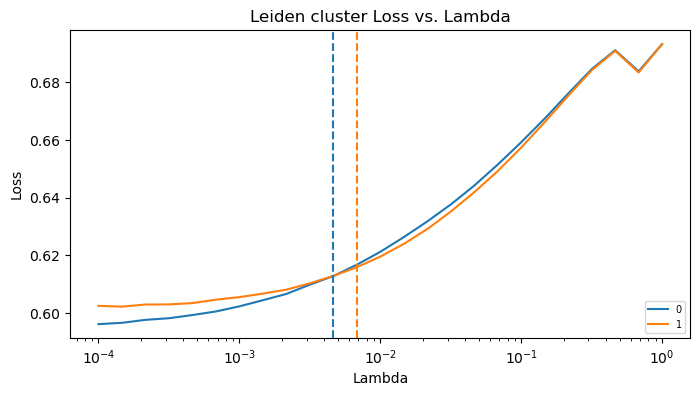

In [12]:
# Plot the loss history against lambda
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 4))

# plot the y-axis values for each key in loss_dict
for key in loss_dict:
    ax.plot(lmbd_range, loss_dict[key], label=key, color=color_dict[key])

# add vertical dotted lines at the values in opt_lambda_dict
for key in opt_lambda_dict:
    ax.axvline(x=opt_lambda_dict[key], linestyle='--', color=color_dict[key])

# set the x-axis label
ax.set_xlabel('Lambda')
ax.set_xscale('log')

# set the y-axis label
ax.set_ylabel('Loss')

# add a legend
ax.legend(loc='lower right', fontsize='x-small')

plt.title('Leiden cluster Loss vs. Lambda')
# show the plot
plt.show()

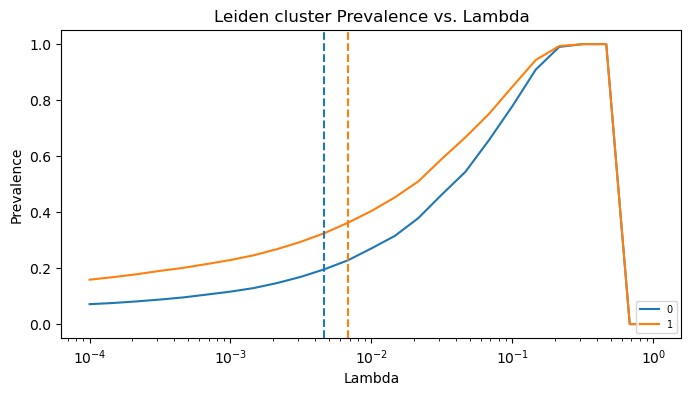

In [13]:
# Plot prevalence against lambda
fig, ax = plt.subplots(figsize=(8, 4))

# plot the y-axis values for each key in loss_dict
for key in prevalence_dict:
    ax.plot(lmbd_range, prevalence_dict[key], label=key, color=color_dict[key])

# add vertical dotted lines at the values in opt_lambda_dict
for key in opt_lambda_dict:
    ax.axvline(x=opt_lambda_dict[key], linestyle='--', color=color_dict[key])

# set the x-axis label
ax.set_xlabel('Lambda')
ax.set_xscale('log')

# set the y-axis label
ax.set_ylabel('Prevalence')

# add a legend
ax.legend(loc='lower right', fontsize='x-small')

plt.title('Leiden cluster Prevalence vs. Lambda')
# show the plot
plt.show()

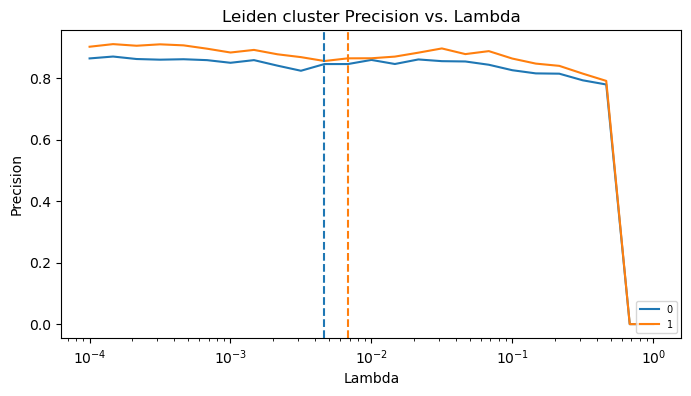

In [14]:
# Plot Precision against lambda
fig, ax = plt.subplots(figsize=(8, 4))

# plot the y-axis values for each key in loss_dict
for key in precision_dict:
    ax.plot(lmbd_range, precision_dict[key], label=key, color=color_dict[key])

# add vertical dotted lines at the values in opt_lambda_dict
for key in opt_lambda_dict:
    ax.axvline(x=opt_lambda_dict[key], linestyle='--', color=color_dict[key])

# set the x-axis label
ax.set_xlabel('Lambda')
ax.set_xscale('log')

# set the y-axis label
ax.set_ylabel('Precision')

# add a legend
ax.legend(loc='lower right', fontsize='x-small')

plt.title('Leiden cluster Precision vs. Lambda')
# show the plot
plt.show()

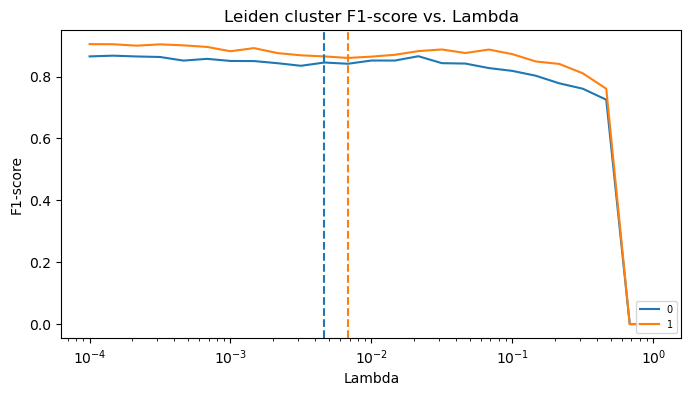

In [15]:
# Plot Precision against lambda
fig, ax = plt.subplots(figsize=(8, 4))

# plot the y-axis values for each key in loss_dict
for key in f1_dict:
    ax.plot(lmbd_range, f1_dict[key], label=key, color=color_dict[key])

# add vertical dotted lines at the values in opt_lambda_dict
for key in opt_lambda_dict:
    ax.axvline(x=opt_lambda_dict[key], linestyle='--', color=color_dict[key])

# set the x-axis label
ax.set_xlabel('Lambda')
ax.set_xscale('log')

# set the y-axis label
ax.set_ylabel('F1-score')

# add a legend
ax.legend(loc='lower right', fontsize='x-small')

plt.title('Leiden cluster F1-score vs. Lambda')
# show the plot
plt.show()

## Count feature number

In [13]:
!pwd

/home/evanlee/PBMC_Hao/Level_2_alpha0.001/Level2_alpha0.001_result


In [17]:
feature_no_df = pd.DataFrame(columns=['Celltype', 'Features', 'Positive features'])

In [21]:
i = 0
for celltype in cts:
    try:
#         feature_df = pd.read_csv(f'./{celltype}/{celltype}_features.txt', names=['Gene', 'Weight', 'Tendency'], sep='\t')
        feature_df = pd.read_csv(f'./{celltype}_features.txt', names=['Gene', 'Weight', 'Tendency'], sep='\t')
    except:
        print('skipping:', celltype)
        continue
    
    feature_no_df.loc[i] = [celltype, feature_df.shape[0], feature_df[feature_df['Tendency'] == 1].shape[0]]
    print(celltype, 'Feature count:', feature_df.shape[0])
    print(celltype, 'Positive feature count:', feature_df[feature_df['Tendency'] == 1].shape[0])
    print('------------------')
    i += 1

ASDC Feature count: 5278
ASDC Positive feature count: 0
------------------
B_intermediate Feature count: 4447
B_intermediate Positive feature count: 0
------------------
B_memory Feature count: 4284
B_memory Positive feature count: 0
------------------
B_naive Feature count: 4657
B_naive Positive feature count: 8
------------------
CD14_Mono Feature count: 5078
CD14_Mono Positive feature count: 746
------------------
CD16_Mono Feature count: 4789
CD16_Mono Positive feature count: 1
------------------
CD4_CTL Feature count: 3734
CD4_CTL Positive feature count: 0
------------------
CD4_Naive Feature count: 4228
CD4_Naive Positive feature count: 0
------------------
CD4_Proliferating Feature count: 4086
CD4_Proliferating Positive feature count: 0
------------------
CD4_TCM Feature count: 4626
CD4_TCM Positive feature count: 0
------------------
CD4_TEM Feature count: 3926
CD4_TEM Positive feature count: 0
------------------
CD8_Naive Feature count: 4656
CD8_Naive Positive feature count: 0

In [22]:
feature_no_df

,Celltype,Features,Positive features
0,ASDC,5278,0
1,B_intermediate,4447,0
2,B_memory,4284,0
3,B_naive,4657,8
4,CD14_Mono,5078,746
5,CD16_Mono,4789,1
6,CD4_CTL,3734,0
7,CD4_Naive,4228,0
8,CD4_Proliferating,4086,0
9,CD4_TCM,4626,0


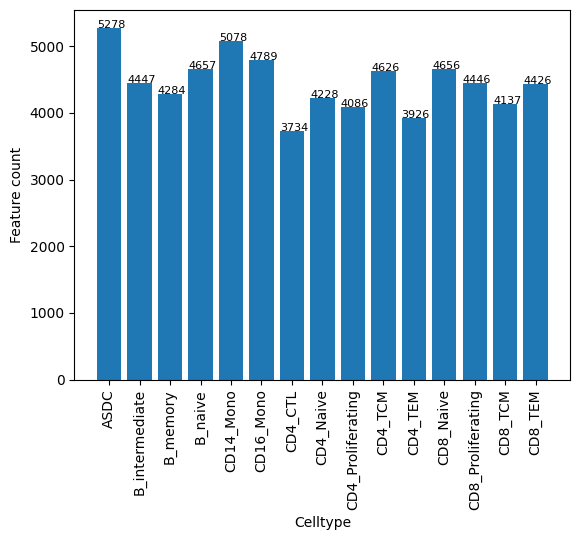

In [28]:
plt.bar(feature_no_df['Celltype'], feature_no_df['Features'])

# Add the values to each bar
for i, v in enumerate(feature_no_df['Features']):
    plt.text(i-0.4, v, str(v), fontsize=8)

# Set the x-axis label
plt.xlabel('Celltype')
plt.xticks(rotation=90)

# Set the y-axis label
plt.ylabel('Feature count')

# Show the plot
plt.show()

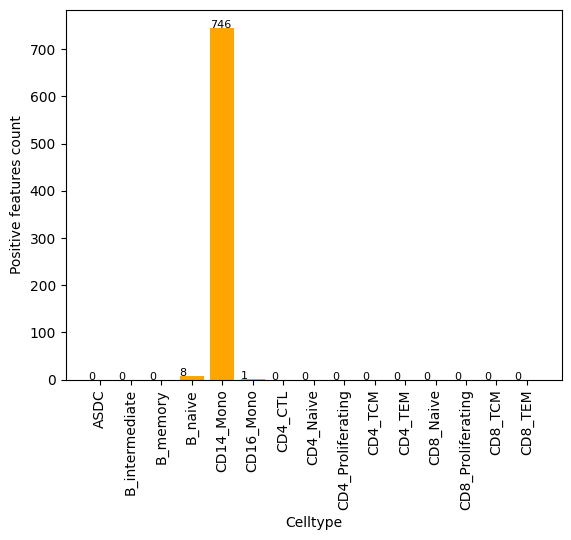

In [30]:
plt.bar(feature_no_df['Celltype'], feature_no_df['Positive features'], color='orange')

# Add the values to each bar
for i, v in enumerate(feature_no_df['Positive features']):
    plt.text(i-0.4, v, str(v), fontsize=8)

# Set the x-axis label
plt.xlabel('Celltype')
plt.xticks(rotation=90)

# Set the y-axis label
plt.ylabel('Positive features count')

# Show the plot
plt.show()